<a href="https://colab.research.google.com/github/gc2321/3235-Machine-Learning/blob/main/XTRA_NEURO_NET_EXERCISES/6_gans_mnist_dcgans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import tensorflow as tf
random.seed(42)

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


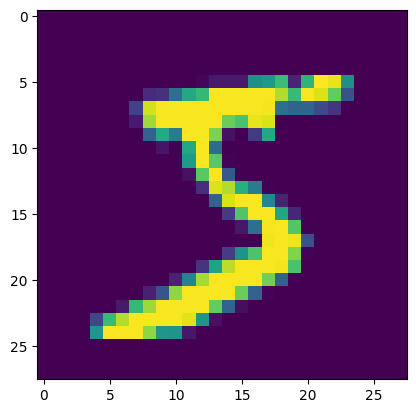

In [4]:
plt.imshow(X_train[0])

In [5]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [6]:
X_train = X_train/255

In [7]:
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [8]:
X_train.min(), X_train.max()

(-1.0, 1.0)

In [9]:
only_zeros = X_train[y_train==0]

In [10]:
only_zeros.shape

(5923, 28, 28, 1)

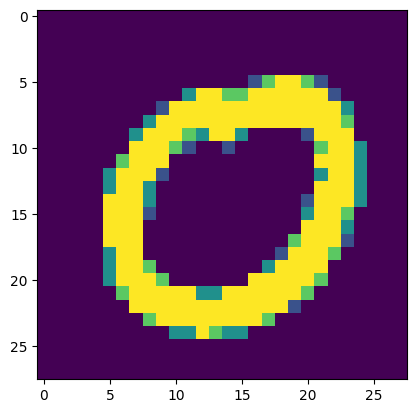

In [11]:
plt.imshow(only_zeros[950])

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

# input size for generator, original size is 784 (28*28)
codings_size = 100

In [15]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

In [16]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [17]:
GAN = Sequential([generator, discriminator])

In [18]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [19]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [20]:
GAN.layers

In [21]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         840705    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1053570 (4.02 MB)
Trainable params: 840321 (3.21 MB)
Non-trainable params: 213249 (833.00 KB)
_________________________________________________________________


## Set up Training Batches

In [22]:
import tensorflow as tf

In [23]:
batch_size = 32

In [24]:
my_data = only_zeros

In [25]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [26]:
type(dataset)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [27]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [28]:
epochs = 20

## Training Loop

In [29]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%20 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################

        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Generate numbers based just on noise input
        gen_images = generator(noise)

        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)

        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

        # This gets rid of a Keras warning
        discriminator.trainable = True

        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)


        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################

        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)

        # Avois a warning
        discriminator.trainable = False

        GAN.train_on_batch(noise, y2)

print("TRAINING COMPLETE")

Currently on Epoch 1
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 2
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 3
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185

In [30]:
# generate 10 fake images, of size 100
noise = tf.random.normal(shape=[10, codings_size])

In [31]:
noise.shape

TensorShape([10, 100])

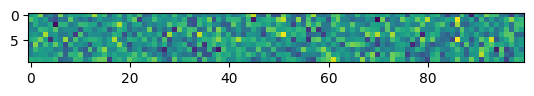

In [32]:
plt.imshow(noise)

In [36]:
images = generator(noise)

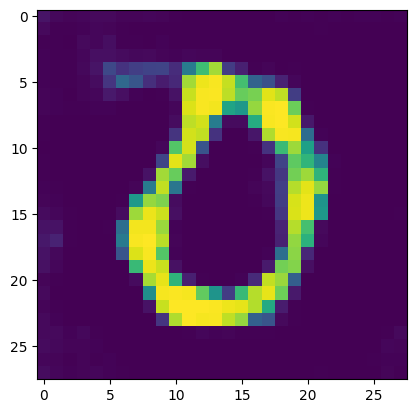

In [37]:
plt.imshow(images[5])

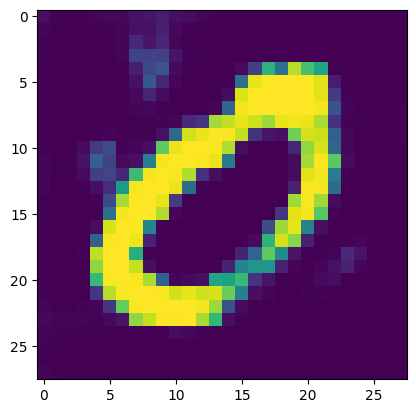

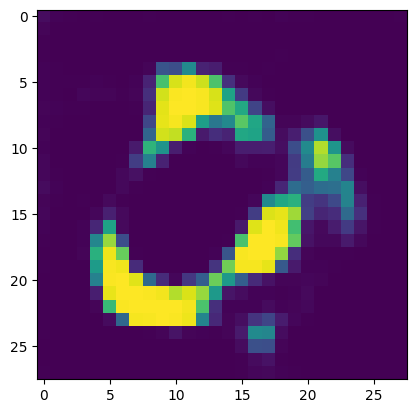

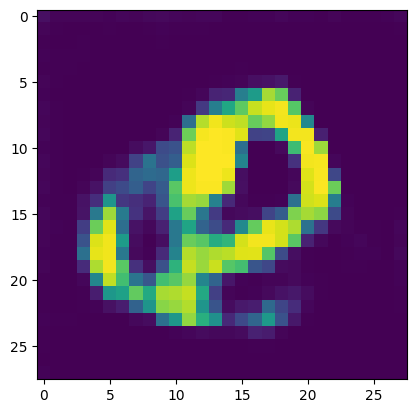

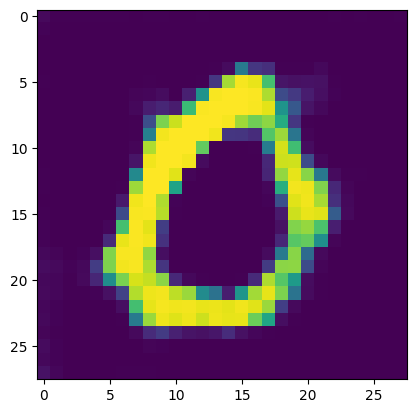

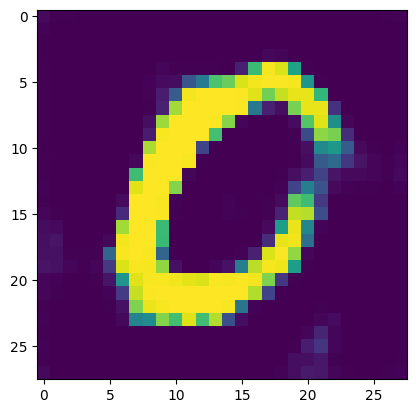

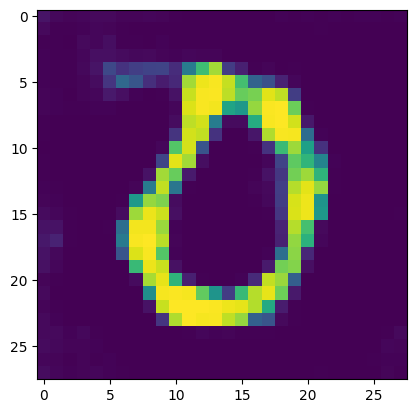

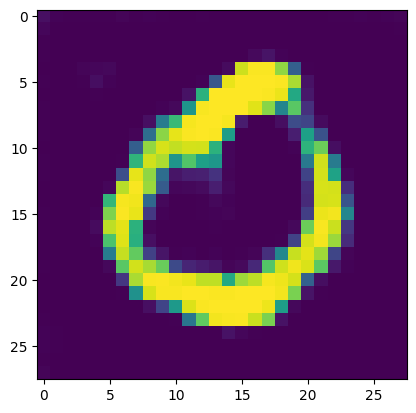

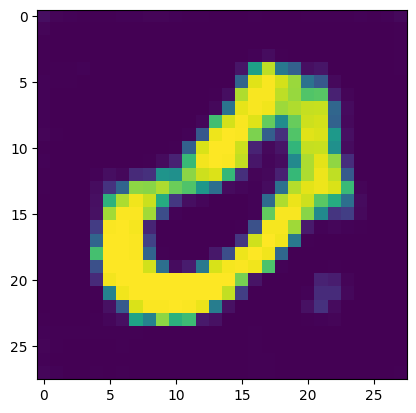

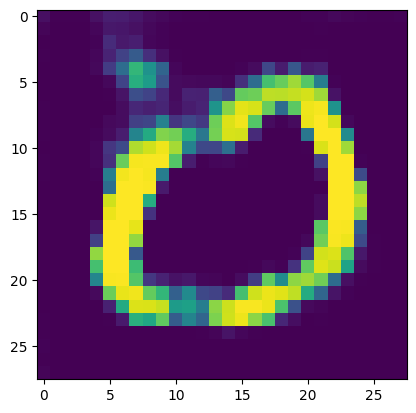

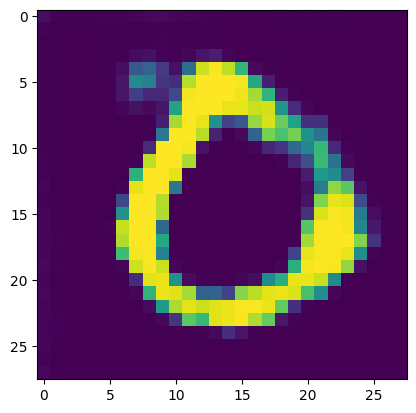

In [38]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()